In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# from fbprophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Análise da Série Temporal

In [2]:

df = pd.read_excel('PVC-2018-2023.xlsx', sheet_name='PVC', index_col=[0], parse_dates=[0])

#Fornece um resumo abrangente com: contagem, média, desvio padrão, quartis, mínimo, máximo
df.head()
df.describe()


,PVC BRL/tonne
count,307.000000
mean,6787.217811
std,2520.058991
min,4244.046000
25%,4953.490500
50%,5545.474000
75%,8749.944500
max,13818.727000


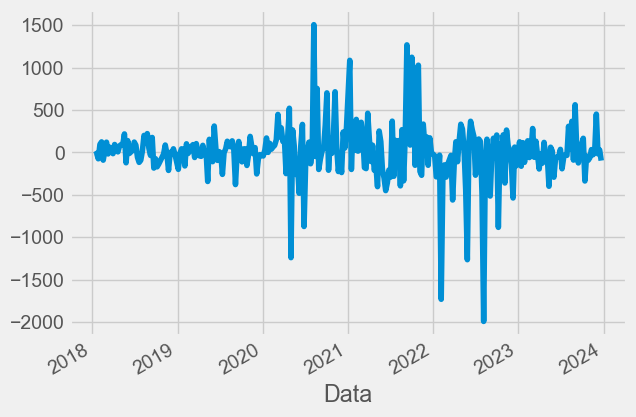

In [3]:
#Calcula a diferença entre valores consecutivos.
#Útil para analisar a mudança nos preços do PVC ao longo do tempo.
print()
df['Diferença'] = df['PVC BRL/tonne'].diff()
df['Diferença'].plot()


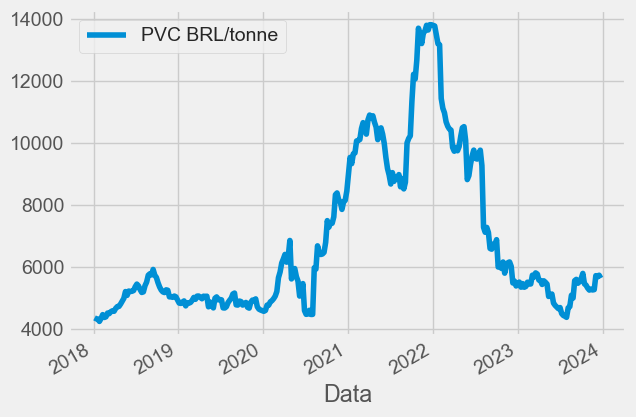

In [4]:
#Agrupa os dados por uma ou mais colunas e aplica funções agregadas.
#Útil para comparar preços por mês, ano, etc.

df_ano = df.groupby('Data').agg({'PVC BRL/tonne': 'mean'})
df_ano.plot()


## Decomposição Sazonal da Série Temporal:
Em análise de séries temporais, podemos nos deparar com os seguintes elementos:
- Tendência: A direção geral dos dados ao longo do tempo, indicando se a série está aumentando, diminuindo ou mantendo-se estável.
- Sazonalidade: Variações periódicas ou sazonais que ocorrem em intervalos regulares de tempo, como padrões que se repetem anualmente, mensalmente ou semanalmente.
- Ciclo: Flutuações não sazonais repetitivas que geralmente são de longo prazo e não têm um padrão fixo, podendo ser influenciadas por fatores econômicos, políticos ou sociais.
- Resíduo:  A parte da série temporal que não é explicada pela tendência, sazonalidade ou ciclo, representando as variações aleatórias ou não sistemáticas dos dados.

Utilizaremos ferramentas da linguagem Python para decompor a série nos quatro componentes acima, no que chamamos de modelo aditivo:
$$ y(t) = T(t) + S(t) + C(t) + E(t) $$
Em que:
- y representa a série:
- T é o componente de tendência
- S é o componente de sazonalidade
- C é o componente dos ciclos
- E representa os resíduos.

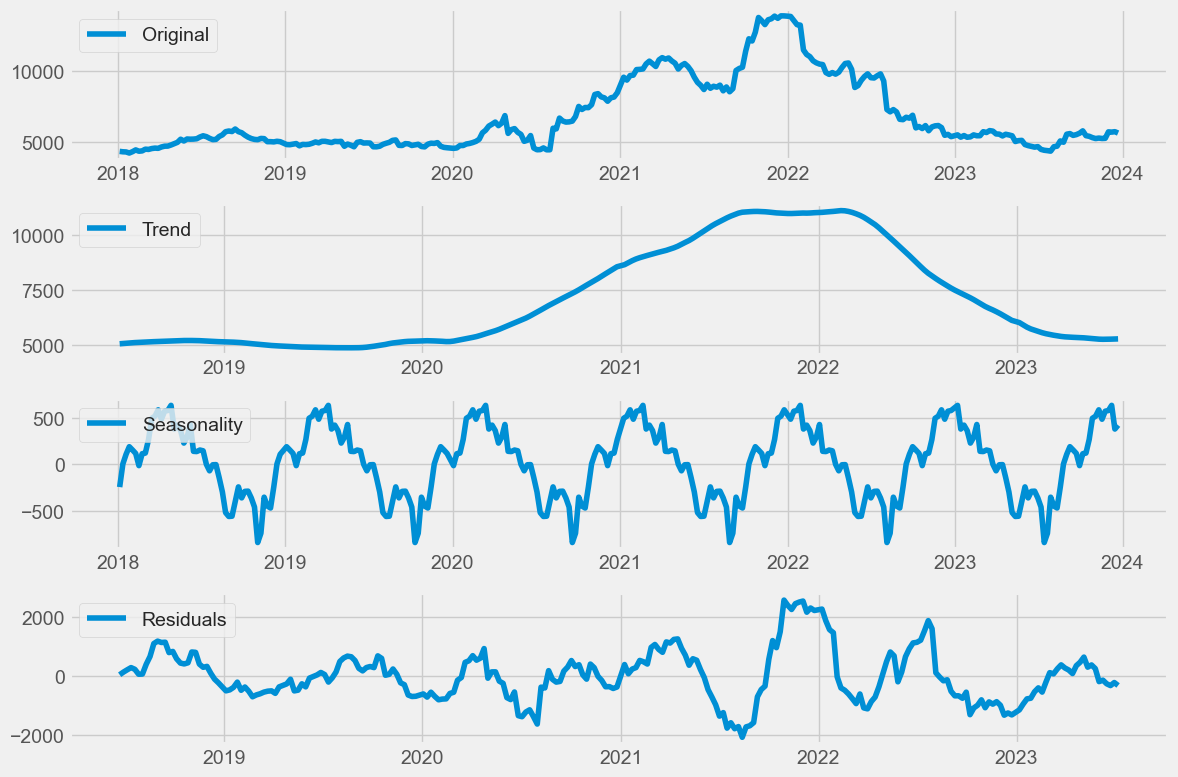

In [5]:
result = seasonal_decompose(df['PVC BRL/tonne'], model='additive', period=48)

# plotting results
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(df['PVC BRL/tonne'], label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(result.trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(result.seasonal,label='Seasonality')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(result.resid, label='Residuals')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

## Análise de sazonalidade

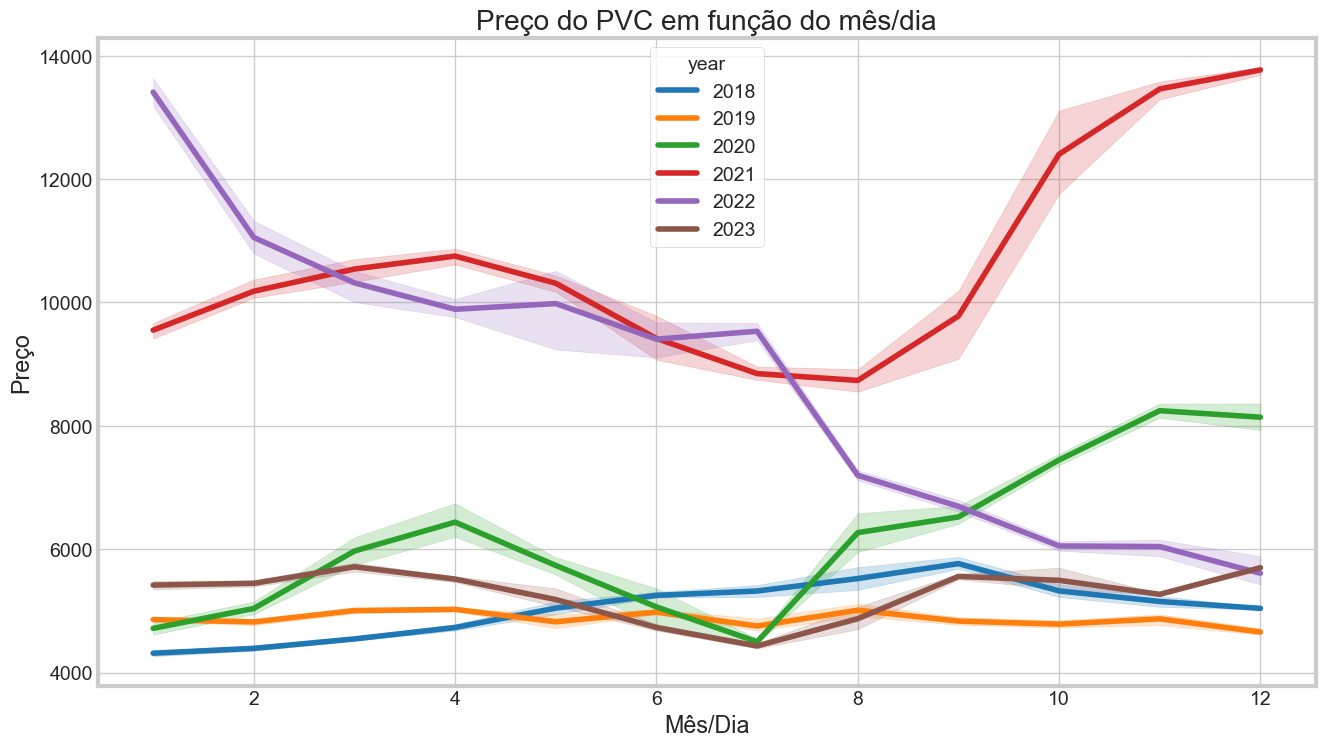

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_excel('PVC-2018-2023.xlsx', header=0)

df['Data'] = pd.to_datetime(df['Data'])
df['year'] = df['Data'].dt.year
df['month'] = df['Data'].dt.month
df['month_day'] = df['Data'].dt.strftime('%m-%d')

df = df.sort_values(by='month_day', ascending=False)
# para escolher vários anos, usar o método isin
df = df[df['year'].isin([2018, 2019, 2020, 2021, 2022, 2023])]

sns.set_style("whitegrid")
plt.figure(figsize=(14, 8))
sns.lineplot(data=df, x='month', y='PVC BRL/tonne', hue='year', palette='tab10', legend='full')

plt.xlabel('Mês/Dia')
plt.ylabel('Preço')
plt.title('Preço do PVC em função do mês/dia')

plt.show()

## Gráfico de pontos e Box Plot

In [7]:
# Load data
pvc = pd.read_excel('PVC-2018-2023.xlsx', sheet_name='PVC', index_col=[0], parse_dates=[0])

pvc.head()

,PVC BRL/tonne
Data,
2018-01-05,4358.329
2018-01-12,4330.645
2018-01-19,4319.530
2018-01-26,4244.046
2018-02-02,4338.827


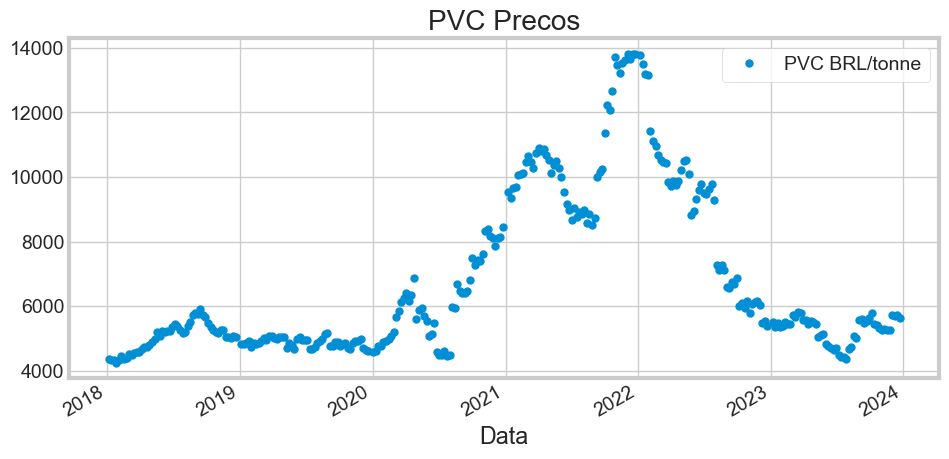

In [8]:
color_pal = sns.color_palette()
pvc.plot(style='.',
          figsize=(10, 5),
          ms=10,
          color=color_pal[0],
          title='PVC Precos')
plt.show()

In [9]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday','Tuesday',
                                        'Wednesday',
                                        'Thursday','Friday',
                                        'Saturday','Sunday'],
                            ordered=True)

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300],
                          labels=['Spring', 'Summer', 'Fall', 'Winter']
                   )
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','weekday',
           'season']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(pvc, label='PVC BRL/tonne')
features_and_target = pd.concat([X, y], axis=1)


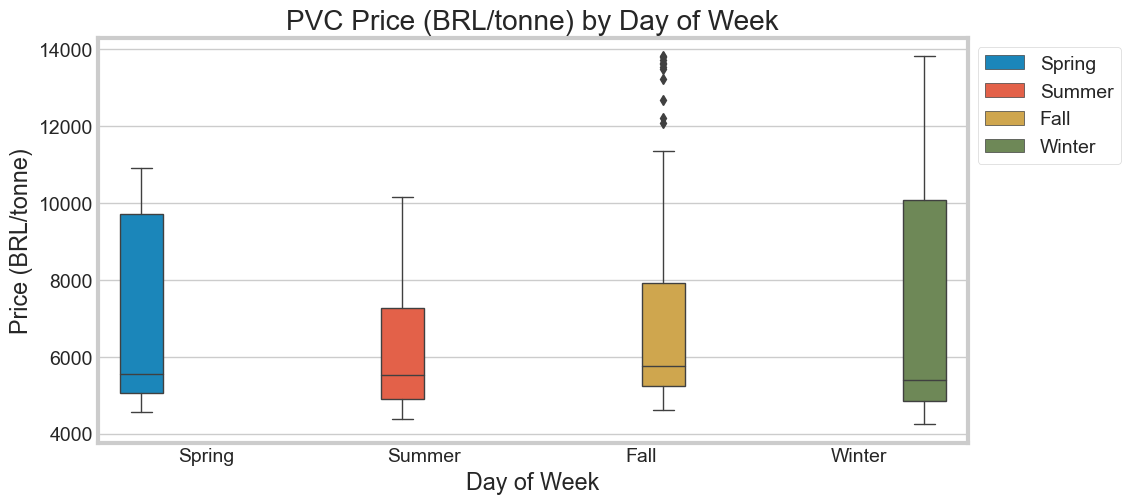

In [10]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_and_target.dropna(),
            x='season',  # Assuming your weekday column is named 'weekday'
            y='PVC BRL/tonne',  # Replace with your actual price column name
            hue='season',
            ax=ax,
            linewidth=1)
ax.set_title('PVC Price (BRL/tonne) by Day of Week')  # Adjust title as needed
ax.set_xlabel('Day of Week')
ax.set_ylabel('Price (BRL/tonne)')  # Adjust y-axis label
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

## Redução de ruídos:
Utiliza exponencial moving acerage para retirar movimentações aleatórias do preço.

<function matplotlib.pyplot.show(*args, **kw)>

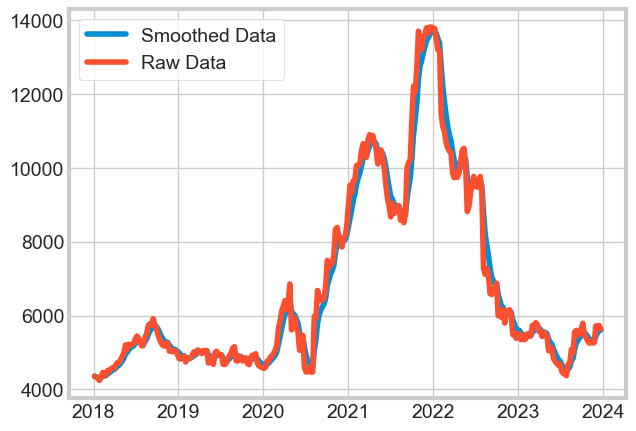

In [11]:
smooth = pvc.ewm(com=2).mean()
plt.plot(smooth, label='Smoothed Data')
plt.plot(pvc, label='Raw Data')
plt.legend()
plt.show

In [12]:
smooth["Noise diff"] = abs(smooth - pvc)
average_noise_diff = round(smooth["Noise diff"].mean(), 2)
print(f"Variação aleatória média: {average_noise_diff} BRL")

Variação aleatória média: 221.5 BRL


## Comparação dos gráficos

In [13]:
#ler os dados
import pandas as pd
# ler os arquivos excel
pvc = pd.read_excel('PVC-2018-2023.xlsx', sheet_name='PVC', index_col=[0], parse_dates=[0])
cl2 = pd.read_excel('Cl2-2018-2023.xlsx', sheet_name='Cl2', index_col=[0], parse_dates=[0])
incc = pd.read_excel('INCC-DI-2018-2023.xlsx', sheet_name='INCC', index_col=[0], parse_dates=[0])
icst = pd.read_excel('ICST-2018-2023.xlsx', sheet_name='ICST', index_col=[0], parse_dates=[0])
dolar = pd.read_excel('USD_BRL-2018-2023.xlsx', sheet_name='USD_BRL', index_col=[0], parse_dates=[0])

In [14]:
from sklearn.preprocessing import MinMaxScaler
# Normalizando os dados
scaler = MinMaxScaler()

# Normalizando PVC
pvc_normalized = scaler.fit_transform(pvc.values.reshape(-1, 1))

# Normalizando cl2
cl2_normalized = scaler.fit_transform(cl2.values.reshape(-1, 1))

# Normalizando INCC
incc_normalized = scaler.fit_transform(incc.values.reshape(-1, 1))

# Normalizando ICST
icst_normalized = scaler.fit_transform(icst.values.reshape(-1, 1))

# Normalizando USD_BRL
dolar_normalized = scaler.fit_transform(dolar.values.reshape(-1, 1))


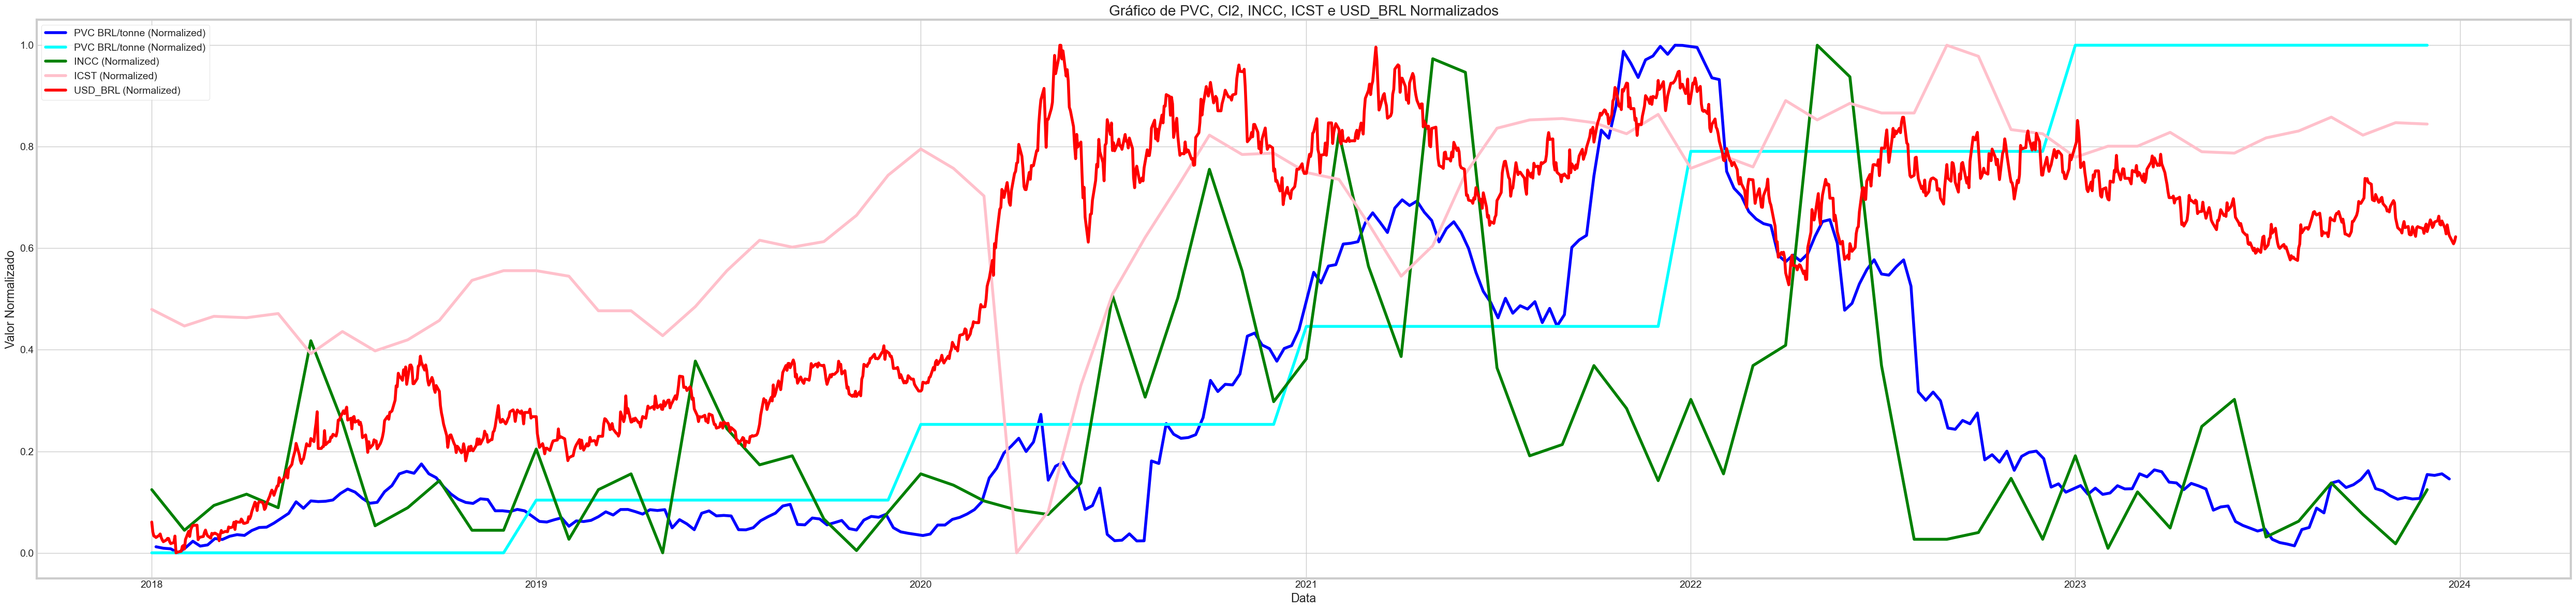

In [15]:
# Plotando os dados normalizados
import matplotlib.pyplot as plt

plt.figure(figsize=(50, 12))

# Plotando PVC
plt.plot(pvc.index, pvc_normalized, label='PVC BRL/tonne (Normalized)', color='blue')

# Plotando Cl2
plt.plot(cl2.index, cl2_normalized, label='PVC BRL/tonne (Normalized)', color='cyan')

# Plotando INCC
plt.plot(incc.index, incc_normalized, label='INCC (Normalized)', color='green')

# Plotando ICST
plt.plot(icst.index, icst_normalized, label='ICST (Normalized)', color='pink')

# Plotando USD_BRL
plt.plot(dolar.index, dolar_normalized, label='USD_BRL (Normalized)', color='red')

# Adicionando rótulos e título
plt.xlabel('Data')
plt.ylabel('Valor Normalizado')
plt.title('Gráfico de PVC, Cl2, INCC, ICST e USD_BRL Normalizados')
plt.legend()

# Exibindo o gráfico
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
# Defina o índice de todas as séries como um objeto datetime, se já não estiverem
cl2.index = pd.to_datetime(cl2.index)
incc.index = pd.to_datetime(incc.index)
icst.index = pd.to_datetime(icst.index)
dolar.index = pd.to_datetime(dolar.index)

# Resample de todas as séries mensais para uma frequência diária e interpolação linear
cl2_daily = cl2.resample('D').interpolate(method='linear')
incc_daily = incc.resample('D').interpolate(method='linear')
icst_daily = icst.resample('D').interpolate(method='linear')
dolar_daily = dolar.resample('D').interpolate(method='linear')
pvc_daily = pvc.resample('D').interpolate(method='linear')

# Resample de todas as séries diárias para uma frequência semanal (sexta-feira)
cl2_weekly = cl2_daily.resample('W-Fri').asfreq()
incc_weekly = incc_daily.resample('W-Fri').asfreq()
icst_weekly = icst_daily.resample('W-Fri').asfreq()
dolar_weekly = dolar_daily.resample('W-Fri').asfreq()
pvc_weekly = pvc_daily.resample('W-Fri').asfreq()

# Min-Max normalization
cl2_min = cl2_weekly.min()
cl2_max = cl2_weekly.max()
cl2_normalized = (cl2_weekly - cl2_min) / (cl2_max - cl2_min)

incc_min = incc_weekly.min()
incc_max = incc_weekly.max()
incc_normalized = (incc_weekly - incc_min) / (incc_max - incc_min)

icst_min = icst_weekly.min()
icst_max = icst_weekly.max()
icst_normalized = (icst_weekly - icst_min) / (icst_max - icst_min)

dolar_min = dolar_weekly.min()
dolar_max = dolar_weekly.max()
dolar_normalized = (dolar_weekly - dolar_min) / (dolar_max - dolar_min)

pvc_min = pvc_weekly.min()
pvc_max = pvc_weekly.max()
pvc_normalized = (pvc_weekly - pvc_min) / (pvc_max - pvc_min)


In [17]:
# Combine todas as séries normalizadas em um único DataFrame
data_normalized = pd.DataFrame({
    'PVC_normalized': pvc_normalized["PVC BRL/tonne"],
    'CL2_normalized': cl2_normalized["Preco"],
    'INCC_normalized': incc_normalized["Indice"],
    'ICST_normalized': icst_normalized["Indice"],
    'Dolar_normalized': dolar_normalized["Ultimo"]
}, index=cl2_normalized.index)

# Calcule a matriz de correlação
correlation_matrix = data_normalized.corr()

# Exiba a matriz de correlação
print("Matriz de correlação entre as séries normalizadas:")
print(correlation_matrix)

Matriz de correlação entre as séries normalizadas:
                  PVC_normalized  CL2_normalized  INCC_normalized  \
PVC_normalized          1.000000        0.284373         0.535205   
CL2_normalized          0.284373        1.000000         0.059319   
INCC_normalized         0.535205        0.059319         1.000000   
ICST_normalized         0.389115        0.711725         0.189482   
Dolar_normalized        0.630655        0.629093         0.384629   

                  ICST_normalized  Dolar_normalized  
PVC_normalized           0.389115          0.630655  
CL2_normalized           0.711725          0.629093  
INCC_normalized          0.189482          0.384629  
ICST_normalized          1.000000          0.490613  
Dolar_normalized         0.490613          1.000000  


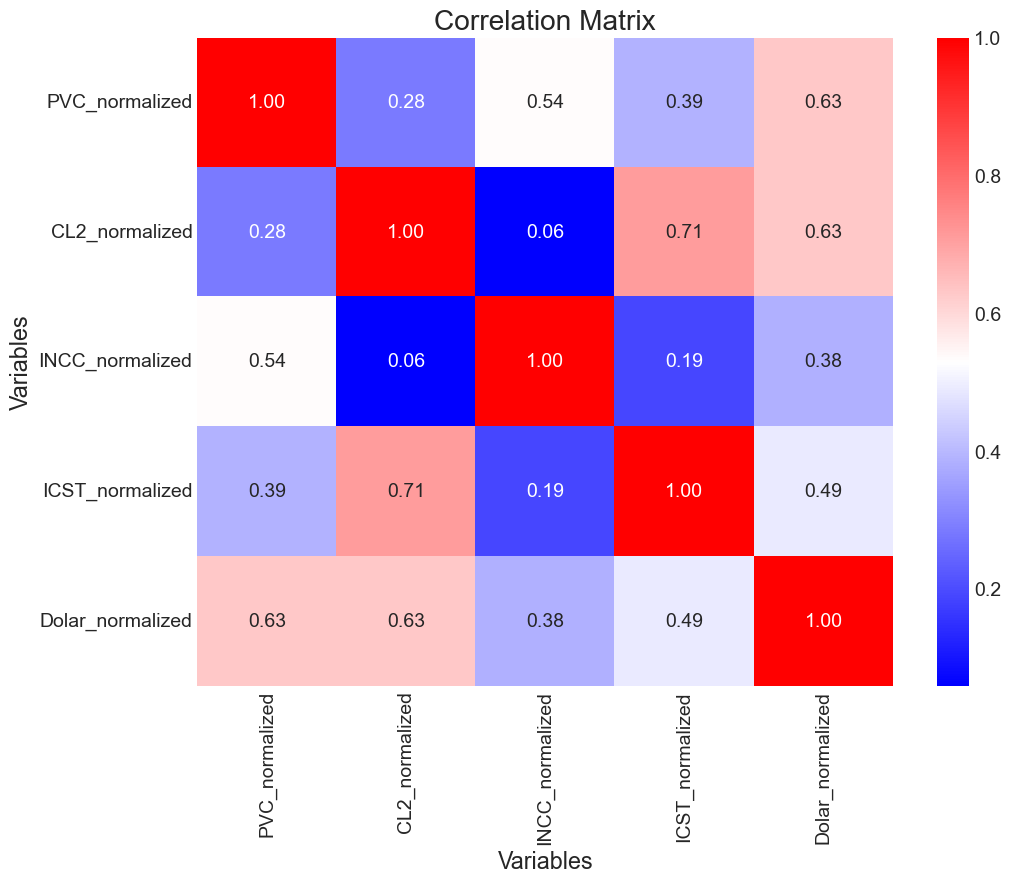

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='bwr', fmt=".2f")
plt.title('Correlation Matrix')
plt.xlabel('Variables')
plt.ylabel('Variables')
plt.show()